In [1]:
from __future__ import division
import imp
import uproot
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
from array import array
import collections

inputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
outputdir = inputdir+'xsec_momentum_wocrt/' 
output_filedir = outputdir
input_filedir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
lib_function_dir = '/home/tmettler/Desktop/uBoone/do_plots/'

plot_systematic = 0

# helper functions
globale = imp.load_source('globale',lib_function_dir+'globale.py')
NuCC = imp.load_source('NuCC_function',lib_function_dir+'NuCC_function.py')
NuCC_w = imp.load_source('NuCCWeight_function',lib_function_dir+'NuCCWeight_function.py')

Welcome to JupyROOT 6.10/08


In [2]:
#!jupyter nbconvert --to script numuCCana_xsec_weighted.ipynb

In [3]:
# initialte ROOT default canvas
ROOT.gROOT.SetBatch(ROOT.kTRUE)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


# Cross section for single differnetial in Momentum (no sys)

In [4]:
# Load input files
#inputdir = '/home/thomasm/numuCC/V33/10kevents/'
outputdir_png, outputdir_root,outputdir_pdf = NuCC.prepareOutput2(outputdir)
try:
    os.stat(output_filedir)
except:
    os.mkdir(output_filedir)
RootFile = ROOT.TFile(output_filedir+"xsec_momentum_wocrt.root","RECREATE");

#filename_overlay = 'NuCCana_Overlay_V18_V4.root'
filename_overlay = 'NuCCana_overlay_V26_weight.root'
#filename_overlay = 'NuCCana_overlay_v25_weighted_all.root'
filename_data = 'NuCCana_data_V25.root'
filename_ext = 'NuCCana_ext_V25.root'
filename_dirt = 'NuCCana_dirt_V26_weight.root'
    
tree_name = 'numuCCAna'

In [5]:
#Open all the trees of the four files (data, ext, dirt, overlay)

data, ext, dirt, overlay = NuCC.openTrees(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
NuCC.printNumberOfEntries(data,ext,dirt,overlay)

pot_overlay = NuCC.getPOT(inputdir,filename_overlay,tree_name)
pot_dirt =  NuCC.getPOT(inputdir,filename_dirt,tree_name)
#V25 files
pot_data =    7.644e+18  # best with tor875
data_trigger = 1838700.0 #2220362.0 #1854495.0 #4743794 # 1987072.0 # E1DCNT_wcut
ext_trigger =  18997529.0  #2120135 #5685315 # EXT

print 'POT: '
print 'Data:\t\t', pot_data
print 'Ext:\t\t', 0
print 'Overlay:\t', pot_overlay
print 'Dirt:\t\t', pot_dirt
print ''
sample = [data,ext,overlay,dirt]
scale = {data:1.0,ext:1.0,overlay:1.0,dirt:1.0}
name = {data:'data',ext:'ext',overlay:'overlay',dirt:'dirt'}

scale[data], scale[ext], scale[dirt], scale[overlay] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)

scale[dirt] = scale[dirt]
scale[overlay] = scale[overlay]
print 'Scalefactors: '
print 'Data:\t\t', scale[data]
print 'Ext:\t\t', scale[ext]
print 'Overlay:\t', scale[overlay]
print 'Dirt:\t\t', scale[dirt]


Overlay: Number of Entries:	989745
Data: Number of Entries:	28005
Ext: Number of Entries:		222702
Dirt: Number of Entries:	40808

POT: 
Data:		7.644e+18
Ext:		0
Overlay:	1.24025430537e+21
Dirt:		1.25019694173e+20

Scalefactors: 
Data:		1.0
Ext:		0.0967862715198
Overlay:	0.00616325213863
Dirt:		0.0611423668132


Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


In [6]:
if 1:
    filename_overlay = filename_overlay+'out4.root'
    #filename_overlay = 'NuCCana_overlay_points_1kev.rootout2.root'
    filename_data = filename_data+'out4.root'
    filename_ext = filename_ext+'out4.root'
    filename_dirt = filename_dirt+'out4.root'

    tree_name = 't_out'

    data_out, ext_out, dirt_out, overlay_out = NuCC.openTreesOut(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
    NuCC.printNumberOfEntries(data_out,ext_out,dirt_out,overlay_out)

    sample_out = [data_out,ext_out,overlay_out,dirt_out]
    scale_out = {data_out:1.0,ext_out:1.0,overlay_out:1.0,dirt_out:1.0}
    name_out = {data_out:'data',ext_out:'ext',overlay_out:'overlay',dirt_out:'dirt'}

    scale_out[data_out], scale_out[ext_out], scale_out[dirt_out], scale_out[overlay_out] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)
    scale_out[dirt_out] = scale_out[dirt_out]
    scale_out[overlay_out] = scale_out[overlay_out]

Overlay: Number of Entries:	989714
Data: Number of Entries:	28004
Ext: Number of Entries:		222701
Dirt: Number of Entries:	40800



In [7]:
##### flux and number of tragets parameters###
flux = 1.16859e11/1.592e20 # flux per POT per cm2
roh_data = 1.3836 #data denisity g/cm3
roh_MC = 1.3954 # MC denisity g/cm3
mol = 39.95 # g for argon
N_A = 6.022140857e23 # molec/mol avogadro zahl
N_nucleons = 40.0
V_fid = ((254.8-10)-(-1.55+10))*((117.47-10)-(-115.53+10))*((1036.9-50)-(-0.1+10))
print 'Fiducial Volume: ', V_fid
##############################################

beam_flux = flux * pot_data
print 'Beam flux = {:.5e}'.format(beam_flux),' /cm2'
N_tot = roh_data*N_A*N_nucleons*V_fid/mol
print 'Number of target nuclei= {:.5e}'.format(N_tot),' /cm3'

Fiducial Volume:  49184671.35
Beam flux = 5.61099e+09  /cm2
Number of target nuclei= 4.10331e+31  /cm3


In [8]:
# Define signals

fidVol = '(Nu_Vx_sce>(-1.55+10) && Nu_Vx_sce<(254.8-10)) && (Nu_Vy_sce>(-115.53+10) && Nu_Vy_sce<(117.47-10)) &&(Nu_Vz_sce>(-0.1+10) && Nu_Vz_sce<(1036.9-50))'
MCfidVol = '(MCNu_Vx>(-1.55+10) && MCNu_Vx<(254.8-10)) && (MCNu_Vy>(-115.53+10) && MCNu_Vy<(117.47-10)) &&(MCNu_Vz>(-0.1+10) && MCNu_Vz<(1036.9-50))'
numu_signal = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5' # numu CC signal definition
numu_true = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14' # numu CC signal definition
numu_nomu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG!=13 && MCTrackPurity>0.5' # not an MC muon
numu_lowpur = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPurity<0.5' #low purity
numu_nc = 'fidVol && MCfidVol && MCNu_CCNC==1' # nutral current
numu_ov = 'fidVol && !MCfidVol' # out of fiducial
numu_other = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG!=14' # e.g anti nu or nue
#signal = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14'
for x in sample:
    x.SetAlias('muon','(muon_candidate_key==track_key)')
    
num_fidVol = {}
for x in sample:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)
    num_fidVol[x] = x.GetEntries('fidVol && muon')*scale[x]
    
tot_num_fidVol = num_fidVol[ext]+num_fidVol[dirt]+num_fidVol[overlay]
overlay_signals = {'numu_signal','numu_nomu','numu_lowpur','numu_nc','numu_ov','numu_other'}

In [9]:
for x in sample_out:
    x.SetAlias('muon','(track_key == key_muon)')

num_fidVol = {}
for x in sample_out:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)

In [10]:
# Load the global variables for access of functions
NuCC.loadGlobal(data,ext,dirt,overlay,data_out,ext_out,dirt_out,overlay_out,scale,scale_out,tot_num_fidVol,overlay_signals,sample,sample_out, name,name_out, outputdir_png, outputdir_root,outputdir_pdf)
#NuCC.printGlobal()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [11]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

In [12]:
track_start_border_x = '(TrackStart_x_sce <(-1.55+1) || TrackStart_x_sce > (254.8-1))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+1) || TrackEnd_x_sce > (254.8-1))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+1) || TrackStart_y_sce > (117.47-1))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+1) || TrackEnd_y_sce > (117.47-1))'
track_start_border_z = '(TrackStart_z_sce <(0.1+1) || TrackStart_z_sce > (1036.9-1))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+1) || TrackEnd_z_sce > (1039.9-1))'

track_end_uncontained = '(' + track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z+ ')'


data.SetAlias("track_end_uncontained",track_end_uncontained)
ext.SetAlias("track_end_uncontained",track_end_uncontained)
overlay.SetAlias("track_end_uncontained",track_end_uncontained)
dirt.SetAlias("track_end_uncontained",track_end_uncontained)
data_out.SetAlias("track_end_uncontained",track_end_uncontained)
ext_out.SetAlias("track_end_uncontained",track_end_uncontained)
overlay_out.SetAlias("track_end_uncontained",track_end_uncontained)
dirt_out.SetAlias("track_end_uncontained",track_end_uncontained)

data.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-4)<0.9 || crtt0_time==-1)")
ext.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.57+3.195-4)<0.9 || crtt0_time==-1)")
overlay.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
dirt.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
data_out.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.95)<0.9 || crtt0_time==-1)")
ext_out.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.57+3.195-3.95)<0.9 || crtt0_time==-1)")
overlay_out.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
dirt_out.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")

crt_tom_cut = 'nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut'

data.SetAlias("crt_tom_cut",crt_tom_cut)
ext.SetAlias("crt_tom_cut",crt_tom_cut)
overlay.SetAlias("crt_tom_cut",crt_tom_cut)
dirt.SetAlias("crt_tom_cut",crt_tom_cut)
data_out.SetAlias("crt_tom_cut",crt_tom_cut)
ext_out.SetAlias("crt_tom_cut",crt_tom_cut)
overlay_out.SetAlias("crt_tom_cut",crt_tom_cut)
dirt_out.SetAlias("crt_tom_cut",crt_tom_cut)

weight_name = 'EventWeight*TunedCentralValue_Genie'


In [13]:
# calculate total flux integrated cross section:
cut = 'fidVol && muon && TrackLength>8 && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
N_data = data_out.GetEntries(cut)
N_ext  = ext_out.GetEntries(cut)*scale_out[ext_out]
N_dirt = dirt_out.GetEntries(cut)*scale_out[dirt_out]
N_overlay = overlay_out.GetEntries(cut+'&& !numu_signal')*scale_out[overlay_out]
N_signal = overlay_out.GetEntries(cut+'&& numu_signal')*scale_out[overlay_out]
N_true = overlay_out.GetEntries('numu_true')*scale_out[overlay_out]

h_weight_func = ROOT.TH1F("h_weight_func",'h_weight_func',10000,0,1000)
globale.overlay_out.Draw(weight_name+'>>h_weight_func',cut+' && 1','0')
dirt_pass_weight = h_weight_func.GetMean() 
globale.overlay_out.Draw(weight_name+'>>h_weight_func',cut+' && numu_signal','0') # weights for signal definition
overlay_signal = h_weight_func.GetMean()
globale.overlay_out.Draw(weight_name+'>>h_weight_func',cut+' && !numu_signal','0') # weights for signal definition
overlay_pass_weight = h_weight_func.GetMean()

overlay_out.Draw(weight_name+'>>h_weight_func',numu_true,'0') # weights for signal definition
overlay_true_weight = h_weight_func.GetMean()

N_dirt = N_dirt*dirt_pass_weight
N_overlay = N_overlay*overlay_pass_weight
N_signal = N_signal*overlay_signal
N_true = N_true*overlay_true_weight
eff = N_signal/N_true

sigma_tot = (N_data- (N_ext+N_dirt+N_overlay))/(eff*beam_flux*N_tot)
print 'Number of data:', N_data
print 'Number of ext:', N_ext
print 'Number of dirt:', N_dirt
print 'Number of overlay:', N_overlay
print 'Number of overlay signal:', N_signal
print 'Efficiency: ',eff
print 'Total integrated cross section:', sigma_tot

sigma_tot_MC = (N_signal)/(eff*beam_flux*N_tot)
print 'Total integrated cross section for MC:', sigma_tot_MC

Number of data: 1720
Number of ext: 366.81996906
Number of dirt: 54.2366118534
Number of overlay: 260.76945829
Number of overlay signal: 1053.83623281
Efficiency:  0.568203199597
Total integrated cross section: 7.93582773864e-39
Total integrated cross section for MC: 8.05555053791e-39


In [14]:
from array import array
mom_bins = [ 0.00, 0.18, 0.30, 0.45, 0.77, 1.28, 2.50 ]
binnum = len(mom_bins) - 1
h_xsec_mom = ROOT.TH1F('h_xsec_mom','h_xsec_mom',binnum,array('f',mom_bins))

In [15]:
def draw_adding():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/30.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()

    pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
    pot_latex.SetTextFont(62);
    pot_latex.SetTextColor(ROOT.kGray+2);
    pot_latex.SetNDC();
    pot_latex.SetTextSize(1/30.);
    pot_latex.SetTextAlign(10) #;//left adjusted
    pot_latex.Draw();
    
    return prelim, pot_latex

def draw_sim():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/30.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()
    
    return prelim

In [16]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


784

Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Histograms are filled with weights
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_wocrt/png/h_eff_trueMom.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_wocrt/root/h_eff_trueMom.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_wocrt/pdf/h_eff_trueMom.pdf has been created


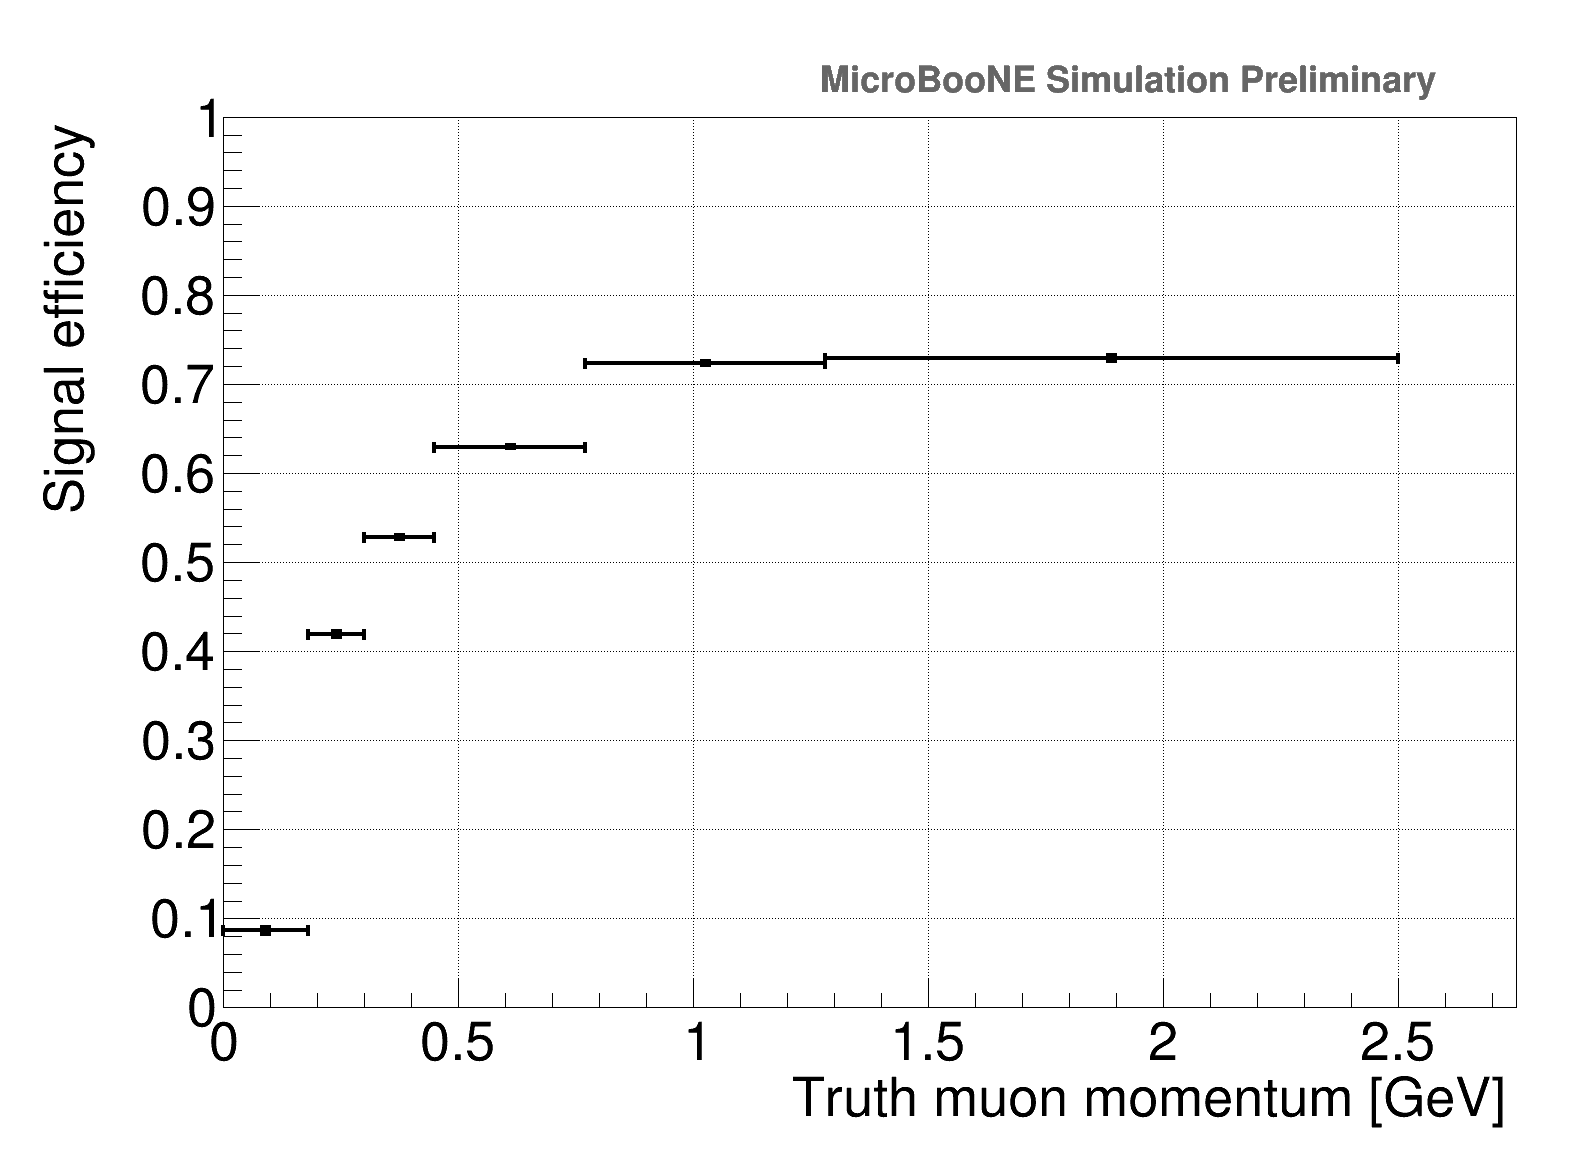

In [17]:
xstart = 0
xend = 2
xbin = 100
weight_name = 'EventWeight*TunedCentralValue_Genie'
title = 'true moum momentum efficiency'
nenner_cut = 'numu_true'
zahler_cut = 'fidVol && muon && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1 && numu_signal'
h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,binnum,array('f',mom_bins))
h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,binnum,array('f',mom_bins))
#h_init_eff_energy = fill_histo(globale.overlay_out,'MCNu_Energy',h_init_eff_energy,zahler_cut)
#h_init_eff_energy_1 = fill_histo(globale.overlay_out,'MCNu_Energy',h_init_eff_energy_1,nenner_cut)
globale.overlay_out.Draw('MCle_Energy>>h_init_eff_energy',weight_name+'*('+zahler_cut+')')
globale.overlay_out.Draw('MCle_Energy>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')
eff =  ROOT.TEfficiency(h_init_eff_energy,h_init_eff_energy_1)
eff.SetStatisticOption(ROOT.TEfficiency.kFCP)#;  // to set option for errors (see ref doc)
eff.SetConfidenceLevel(0.68)
eff.SetTitle(title)
eff.Draw("AP")
ROOT.gPad.Update()
graph = eff.GetPaintedGraph()
graph.SetMinimum(0)
graph.SetMaximum(1)
graph.SetLineWidth(2)
graph.GetXaxis().SetTitle("Truth muon momentum [GeV]")
graph.GetYaxis().SetTitle("Signal efficiency")
graph.GetYaxis().SetTitleSize(0.05)
graph.GetYaxis().SetTitleOffset(0.0)
graph.GetYaxis().SetLabelSize(0.05)
graph.GetXaxis().SetTitleSize(0.05)
graph.GetXaxis().SetLabelSize(0.05)
graph.GetXaxis().SetTitleOffset(1)
graph.SetLineColor(ROOT.kBlack)
graph.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
graph.Draw("AP")
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_eff_trueMom.png")
c1.SaveAs(globale.outputdir_root + "h_eff_trueMom.root")
c1.SaveAs(globale.outputdir_pdf + "h_eff_trueMom.pdf")

eff.Write("h_eff_true")

In [18]:
N_sig = h_init_eff_energy.Integral(0,binnum+1)
N_true = h_init_eff_energy_1.Integral(0,binnum+1)
print N_sig/N_true,N_sig,N_true

0.568199729066 170988.280518 300929.887451


193229

Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_wocrt/root/h2_true_MCS.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_wocrt/png/h2_true_MCS.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_wocrt/pdf/h2_true_MCS.pdf has been created


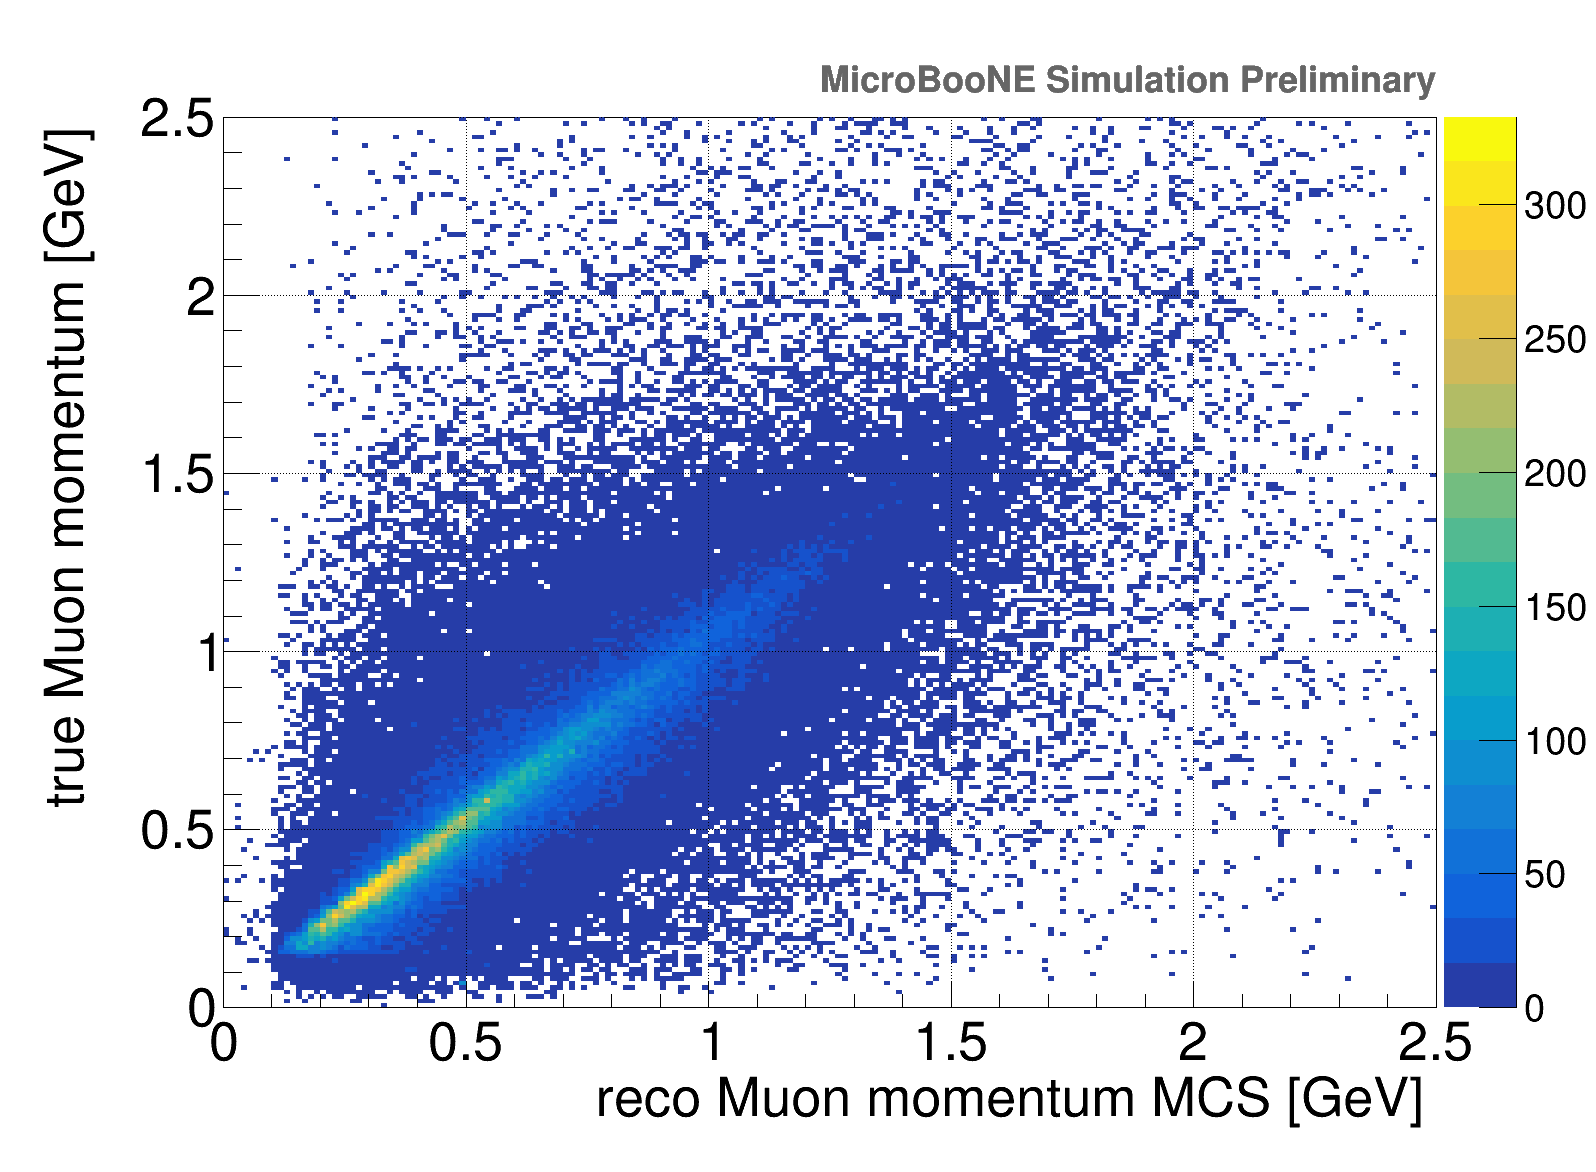

In [19]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',200,0,2.5,200,0,2.5)
globale.overlay_out.Draw('MCle_Energy:TrackMomMCS_mom'+'>>h_migration',weight_name+'*('+cut+'&& numu_true)','')
h_migration.SetXTitle("reco Muon momentum MCS [GeV]")
h_migration.SetYTitle("true Muon momentum [GeV]")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
h_migration.Draw("colz")
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(globale.outputdir_root + "h2_true_MCS.root")
c1.SaveAs(globale.outputdir_png + "h2_true_MCS.png")
c1.SaveAs(globale.outputdir_pdf + "h2_true_MCS.pdf")
h_migration.Write("h2_true_MCS_fine")

1281

Warning in <TFile::Append>: Replacing existing TH1: h_migration (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_wocrt/root/h2_true_MCS_bin.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_wocrt/png/h2_true_MCS_bin.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_wocrt/pdf/h2_true_MCS_bin.pdf has been created


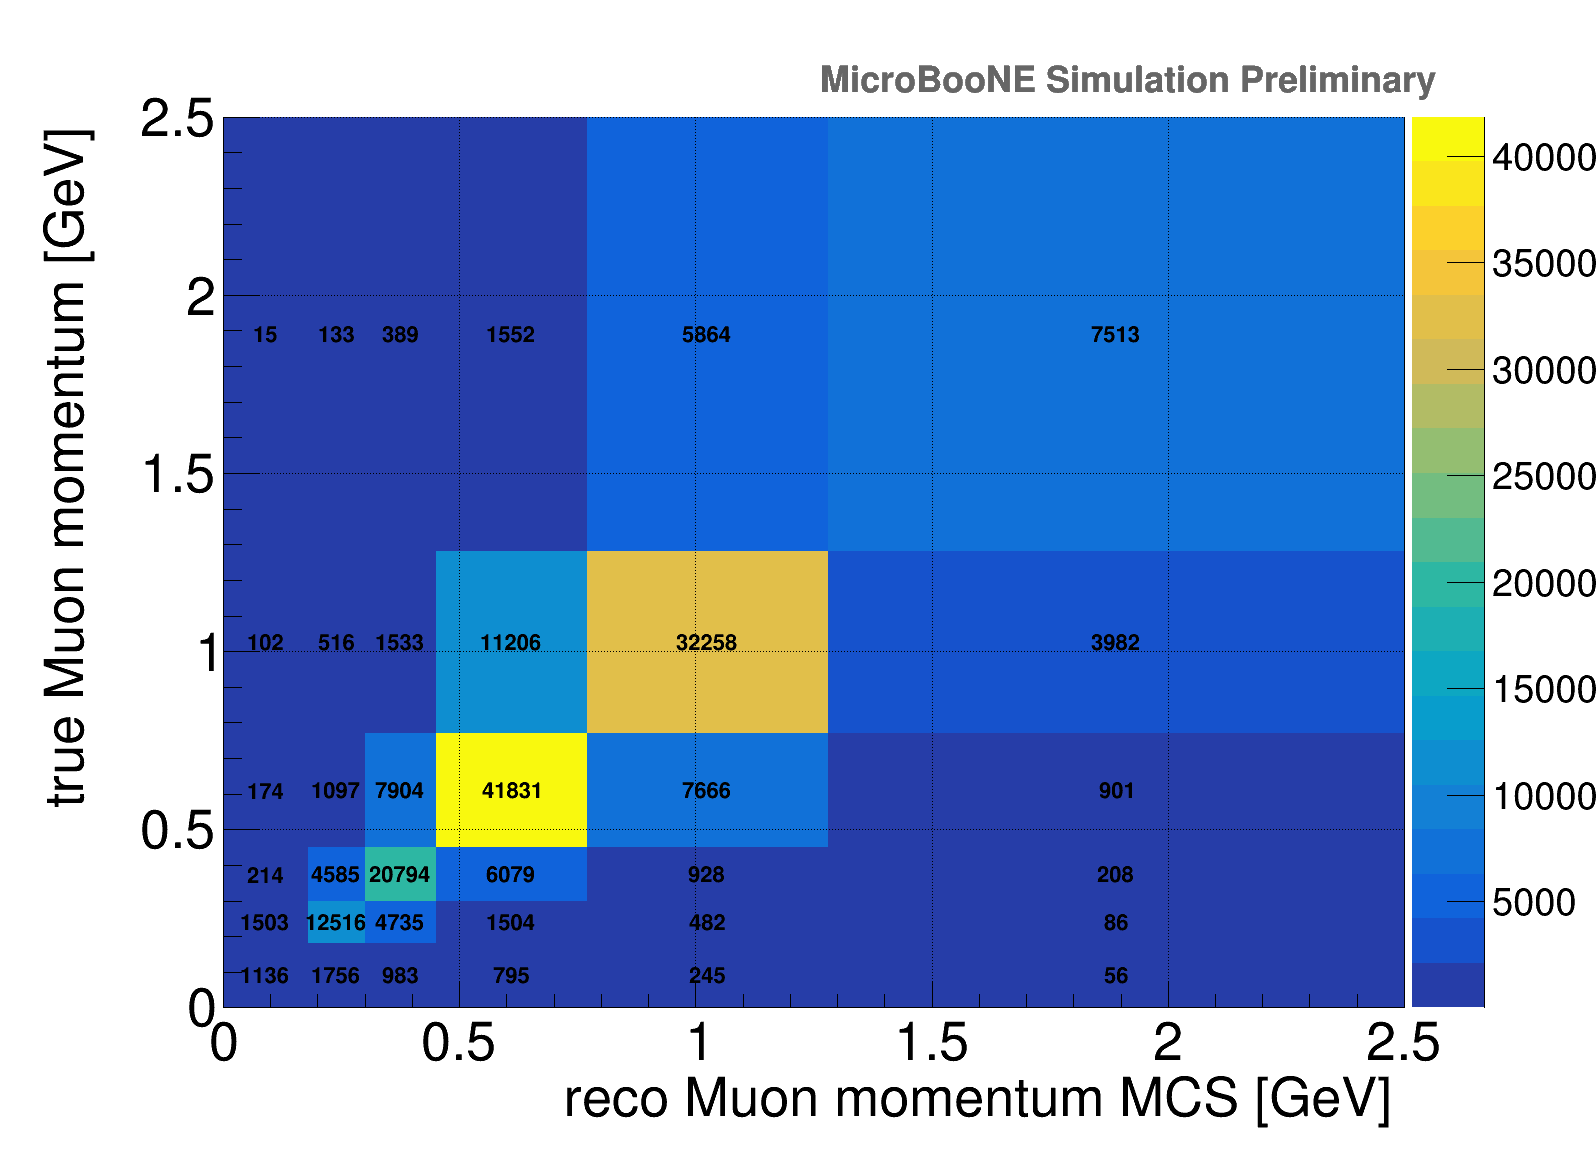

In [20]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',binnum,array('f',mom_bins),binnum,array('f',mom_bins))
globale.overlay_out.Draw('MCle_Energy:TrackMomMCS_mom'+'>>h_migration',weight_name+'*('+cut+'&& numu_true)','')
h_migration.SetXTitle("reco Muon momentum MCS [GeV]")
h_migration.SetYTitle("true Muon momentum [GeV]")
h_migration.Draw("colz")
h_migration.Draw("same text")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.12)
ROOT.gStyle.SetPaintTextFormat('0.0f')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(globale.outputdir_root + "h2_true_MCS_bin.root")
c1.SaveAs(globale.outputdir_png + "h2_true_MCS_bin.png")
c1.SaveAs(globale.outputdir_pdf + "h2_true_MCS_bin.pdf")
h_migration.Write("h2_true_MCS_bin")

[[2.27983126e-01 7.21577060e-02 6.51178277e-03 2.90980602e-03
  2.04843548e-03 9.31710578e-04]
 [3.52427465e-01 6.00692650e-01 1.39609994e-01 1.83746748e-02
  1.03650816e-02 8.49456184e-03]
 [1.97406183e-01 2.27233074e-01 6.33186349e-01 1.32419078e-01
  3.07953587e-02 2.47955675e-02]
 [1.59518567e-01 7.21689311e-02 1.85095731e-01 7.00841223e-01
  2.25071239e-01 9.89827869e-02]
 [4.91424018e-02 2.31297789e-02 2.82670959e-02 1.28440512e-01
  6.47879729e-01 3.74098418e-01]
 [1.13177413e-02 4.14174359e-03 6.33276834e-03 1.51004588e-02
  7.99715041e-02 4.79276860e-01]
 [2.20451608e-03 4.76116102e-04 9.96278632e-04 1.91424695e-03
  3.86865207e-03 1.34200955e-02]]


705

Warning in <TFile::Append>: Replacing existing TH1: h_migration (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_wocrt/png/h_mitigation_matrix.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_wocrt/root/h_mitigation_matrix.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_wocrt/pdf/h_mitigation_matrix.pdf has been created


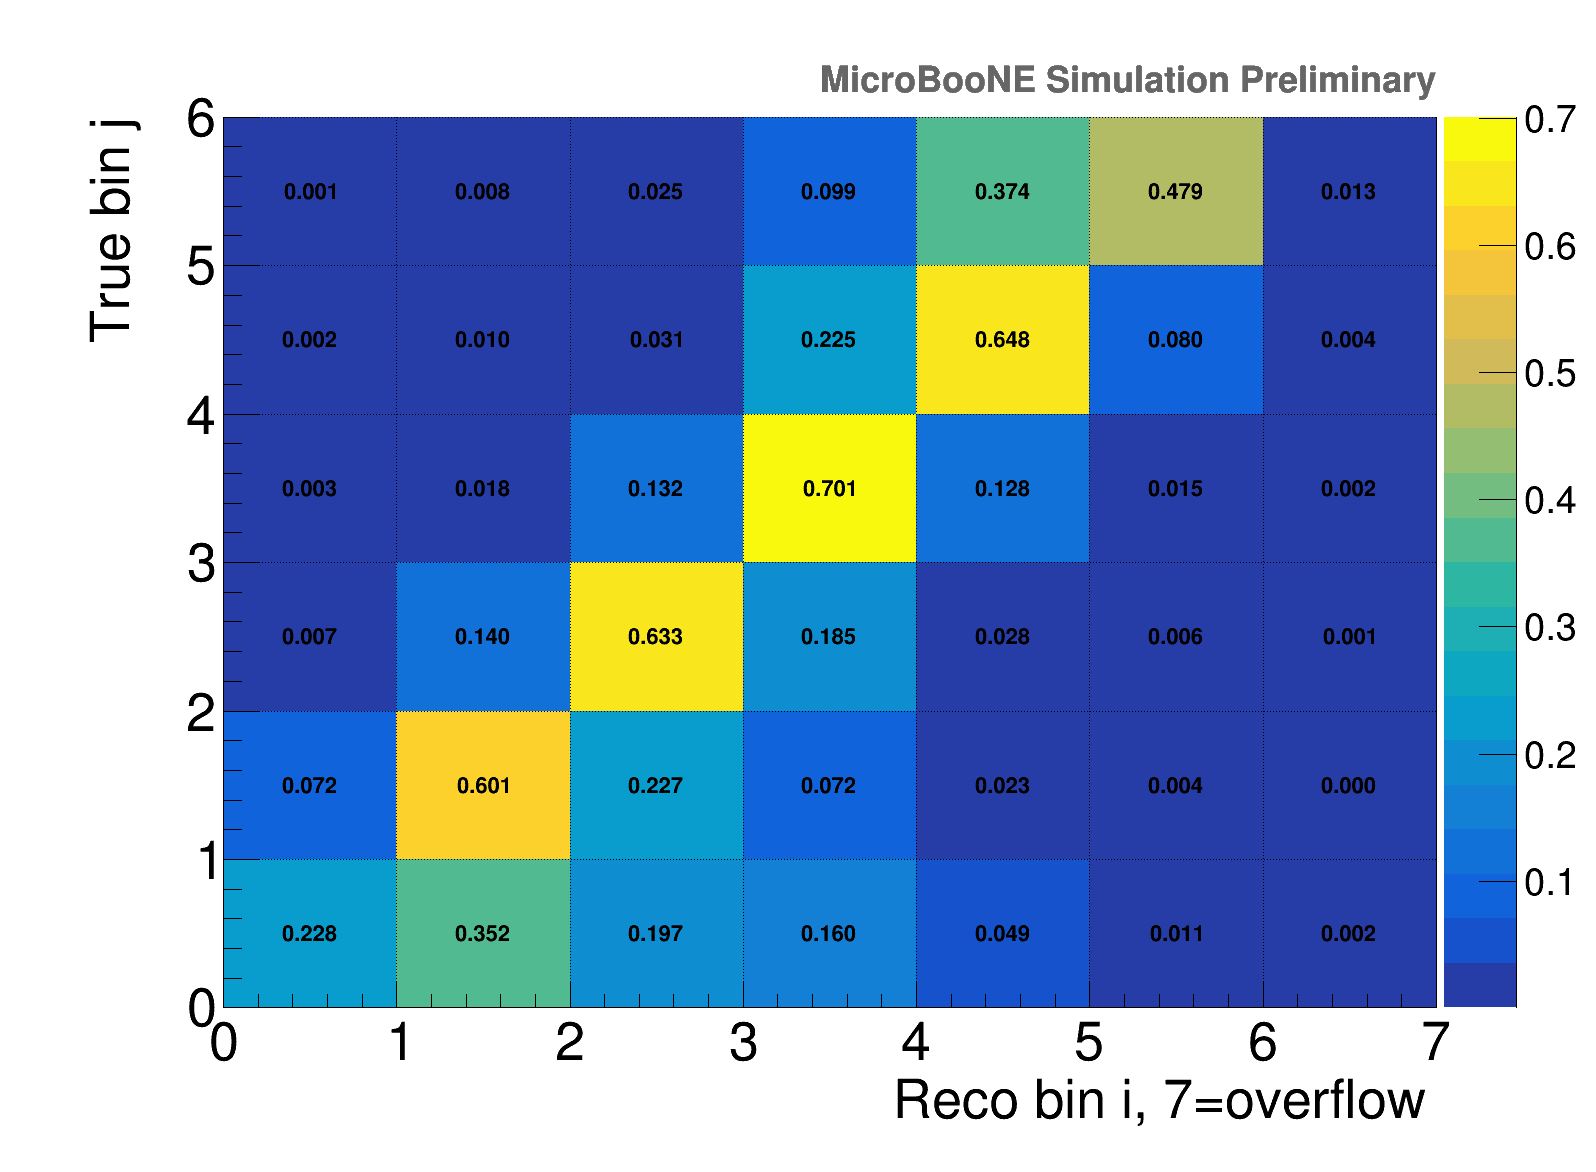

In [21]:
reco_entries = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mitigation_matrix = np.zeros((7,6))
for j in range(1,binnum+1):
    for i in range(1,binnum+2):
        #print 'bin i,j: ', i,j,'Value: ',h_migration.GetBinContent(i,j)
        reco_entries[j-1]+=h_migration.GetBinContent(i,j)
h_mitigation_matrix = ROOT.TH2F("h_migration",'Migration matrix',7,0,7,6,0,6)
for j in range(1,binnum+1):
    for i in range(1,binnum+2):
        #print 'bin i,j: ', i,j,'Value: ',h_migration.GetBinContent(i,j)
        mitigation_matrix[i-1,j-1]= h_migration.GetBinContent(i,j)/reco_entries[j-1]
        h_mitigation_matrix.SetBinContent(i,j,mitigation_matrix[i-1,j-1])
        #print i-1,j-1,mitigation_matrix[i-1,j-1]
        #true_entries[j]+=h_migration.GetBinContent(i,j)
print mitigation_matrix
np.save(output_filedir+'migration_matrix_momentum_wocrt',mitigation_matrix)
h_mitigation_matrix.SetXTitle("Reco bin i, 7=overflow")
h_mitigation_matrix.SetYTitle("True bin j")
h_mitigation_matrix.Draw('colz')
h_mitigation_matrix.Draw('same text')
h_mitigation_matrix.GetYaxis().SetTitleSize(0.05)
h_mitigation_matrix.GetYaxis().SetTitleOffset(0.0)
h_mitigation_matrix.GetYaxis().SetLabelSize(0.05)
h_mitigation_matrix.GetXaxis().SetTitleSize(0.05)
h_mitigation_matrix.GetXaxis().SetLabelSize(0.05)
h_mitigation_matrix.GetXaxis().SetTitleOffset(1)
h_mitigation_matrix.SetLineColor(ROOT.kBlack)
h_mitigation_matrix.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
ROOT.gStyle.SetPaintTextFormat('0.3f')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_mitigation_matrix.png")
c1.SaveAs(globale.outputdir_root + "h_mitigation_matrix.root")
c1.SaveAs(globale.outputdir_pdf + "h_mitigation_matrix.pdf")

h_mitigation_matrix.Write("h_mitigation_matrix")

In [22]:
# Nselected and N generated
title = 'MCS momentum efficiency'
weight_name = 'EventWeight*TunedCentralValue_Genie'
nenner_cut = 'numu_true'
zahler_cut = 'fidVol && muon && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1 && numu_signal'
h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,binnum,array('f',mom_bins))
h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,binnum,array('f',mom_bins))
globale.overlay_out.Draw('MCle_Energy>>h_init_eff_energy',weight_name+'*('+zahler_cut+')')
globale.overlay_out.Draw('MCle_Energy>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')

h_init_eff_energy.Write("h_eff_true_energy_z")
h_init_eff_energy_1.Write("h_eff_true_energy_n")

487

Warning in <TFile::Append>: Replacing existing TH1: h_init_eff_energy (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_init_eff_energy_1 (Potential memory leak).


In [23]:
# e tilde
N_sel = np.zeros((6))
N_gen = np.zeros((6))
for i in range(1,binnum+1):
    N_sel[i-1] = h_init_eff_energy.GetBinContent(i)
    N_gen[i-1] = h_init_eff_energy_1.GetBinContent(i)
    print N_sel[i-1],N_gen[i-1],N_sel[i-1]/N_gen[i-1]
eff_tilde = np.zeros((6))
eff_tilde = mitigation_matrix.dot(N_sel)/(mitigation_matrix.dot(N_gen))
print eff_tilde
np.save(output_filedir+'eff_tilde_momentum_xsec_CV',eff_tilde)


2072.339111328125 23917.890625 0.08664389112817615
16724.779296875 39873.6328125 0.4194445832292447
29738.0 56265.5625 0.5285293291078357
56431.79296875 89653.0390625 0.6294465146843443
48296.50390625 66761.640625 0.723416971993414
15148.9287109375 20789.4296875 0.7286841889677259
[0.23593466 0.38815981 0.50702909 0.60769858 0.68748572 0.70239847
 0.64581281]


In [24]:
h_eff = h_init_eff_energy.Clone()
h_eff.Divide(h_init_eff_energy_1)

True

462

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_wocrt/png/h_eff_tilde_xsecMom.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_wocrt/root/h_eff_tilde_xsecMom.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_wocrt/pdf/h_eff_tilde_xsecMom.pdf has been created


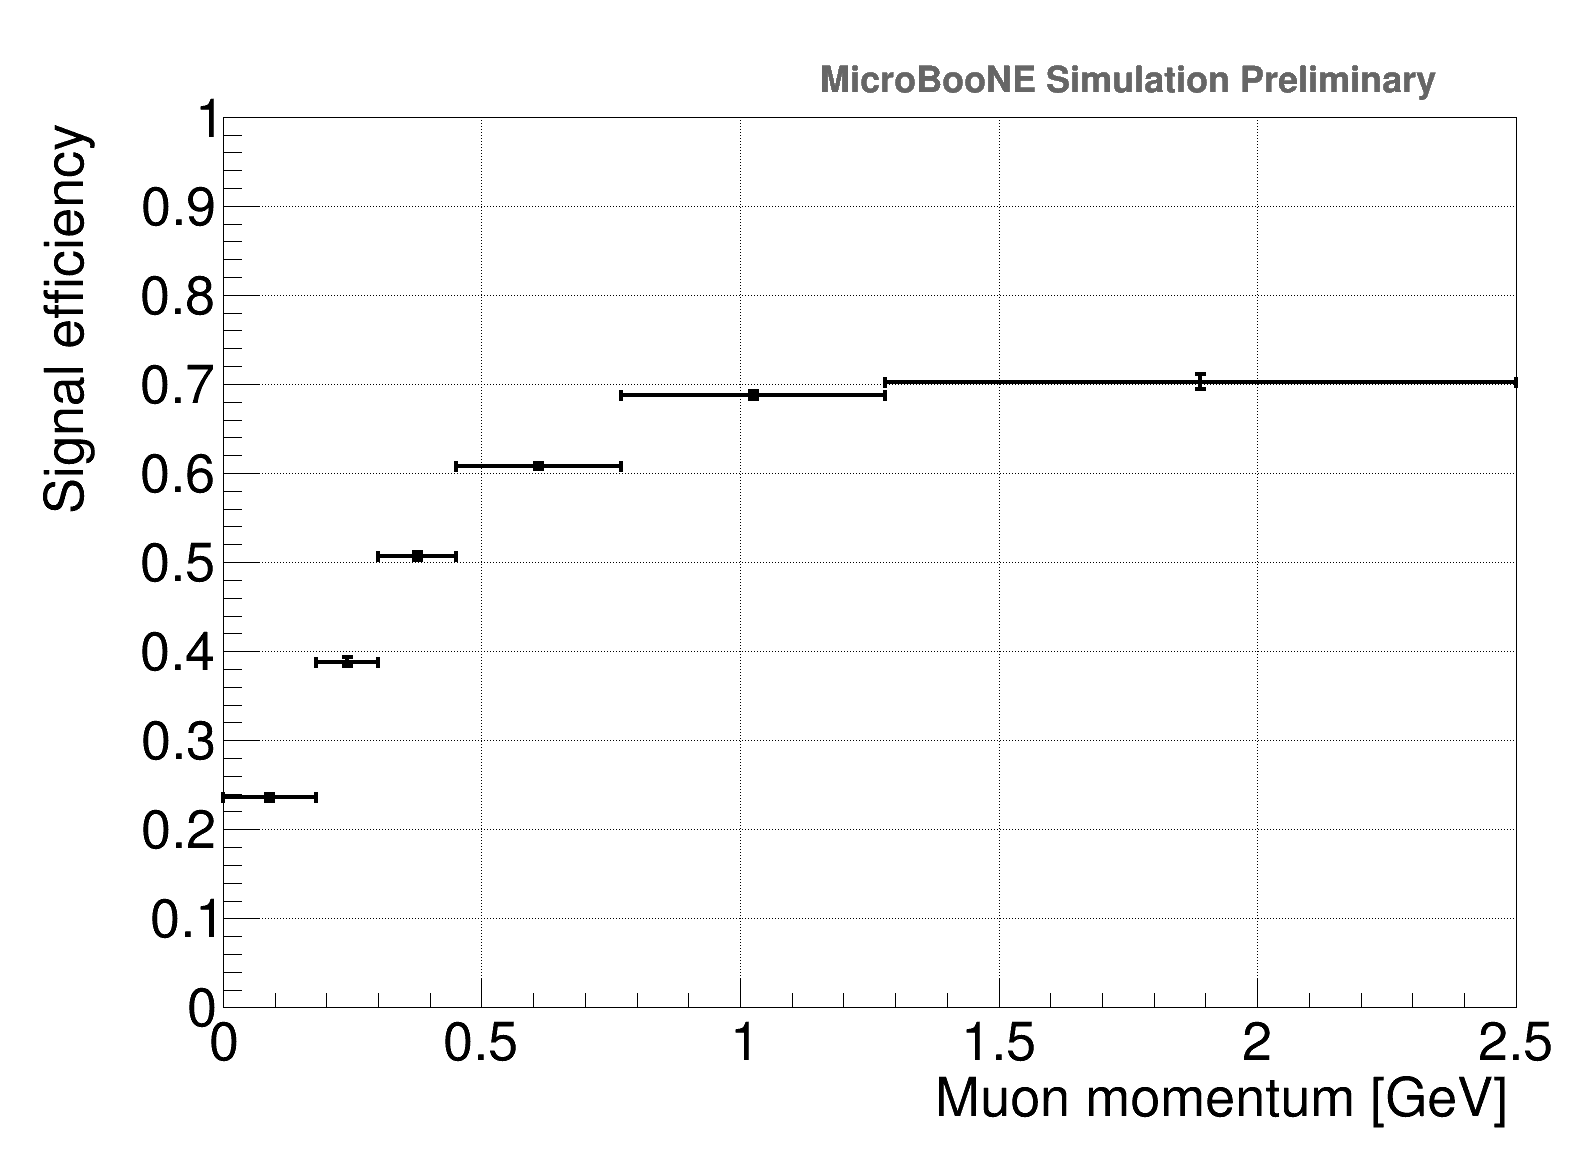

In [25]:
h_eff_tilde = ROOT.TH1F("h_eff_tilde",'Efficiency tilde',binnum,array('f',mom_bins))
for i in range(1,binnum+1):
    h_eff_tilde.SetBinContent(i,eff_tilde[i-1])
    h_eff_tilde.SetBinError(i,h_eff.GetBinError(i))
h_eff_tilde.SetMaximum(1)
h_eff_tilde.SetMinimum(0)
h_eff_tilde.SetLineWidth(3)

h_eff_tilde.SetXTitle("Muon momentum [GeV]")
h_eff_tilde.SetYTitle("Signal efficiency")
h_eff_tilde.GetYaxis().SetTitleSize(0.05)
h_eff_tilde.GetYaxis().SetTitleOffset(0.0)
h_eff_tilde.GetYaxis().SetLabelSize(0.05)
h_eff_tilde.GetXaxis().SetTitleSize(0.05)
h_eff_tilde.GetXaxis().SetLabelSize(0.05)
h_eff_tilde.GetXaxis().SetTitleOffset(1)
h_eff_tilde.SetLineColor(ROOT.kBlack)
h_eff_tilde.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.05)

h_eff_tilde.Draw('E1')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_eff_tilde_xsecMom.png")
c1.SaveAs(globale.outputdir_root + "h_eff_tilde_xsecMom.root")
c1.SaveAs(globale.outputdir_pdf + "h_eff_tilde_xsecMom.pdf")

h_eff_tilde.Write("h_eff_tilde")

In [26]:
weight_name = 'EventWeight*TunedCentralValue_Genie'
variable = 'TrackMomMCS_mom'
cut = 'fidVol && muon && crt_tom_cut && nr_tracks_uncontained==0 && TrackLength>8 && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'

h_data = ROOT.TH1F("h_data",'h_data',binnum,array('f',mom_bins))
h_ext = ROOT.TH1F("h_ext",'h_ext',binnum,array('f',mom_bins))
h_dirt = ROOT.TH1F("h_dirt",'h_dirt',binnum,array('f',mom_bins))
h_overlay = ROOT.TH1F("h_overlay",'h_overlay',binnum,array('f',mom_bins))
h_signal = ROOT.TH1F("h_signal",'h_signal',binnum,array('f',mom_bins))
#h_weight_func_n = ROOT.TH1F("h_weight_func_n",'h_weight_func',binnum,array('f',mom_bins))

globale.data_out.Draw(variable+'>>h_data',cut,'')
globale.ext_out.Draw(variable+'>>h_ext',cut,'')
globale.dirt_out.Draw(variable+'>>h_dirt',weight_name+'*('+cut+')','')
globale.overlay_out.Draw(variable+'>>h_overlay',weight_name+'*('+cut+'&& !numu_signal)','')
globale.overlay_out.Draw(variable+'>>h_signal',weight_name+'*('+cut+'&& numu_signal)','')


61740L

In [27]:
#lat = np.zeros(8,binnum)
for i in range(1,binnum+1):
    print 'Entries in bin ',i,'-------------------------------------------------------------'
    n_da = h_data.GetBinContent(i)
    err_da = math.sqrt(n_da)
    n_ext = h_ext.GetBinContent(i)
    err_ext = math.sqrt(n_ext)
    n_dirt = h_dirt.GetBinContent(i)
    err_dirt = math.sqrt(n_dirt)
    n_ov = h_overlay.GetBinContent(i)
    err_ov = math.sqrt(n_ov)
    n_sig = h_signal.GetBinContent(i)
    err_sig = math.sqrt(n_sig)
    #print 'data: ',n_da, ' +- ',err_da,' Ext: ',n_ext,' +- ',err_ext,\
    #' Dirt: ',n_dirt,' +- ', err_dirt,' Overlay: ',n_ov,' +- ',err_ov,' Signal: ',n_sig,' +- ',err_sig
    #print ''
    print 'data: {0:0.2f}'.format(n_da*scale[data]), ' +- {0:0.2f}'.format(err_da*scale[data])
    print ' Ext: {0:0.2f}'.format(n_ext*scale[ext]),' +- {0:0.2f}'.format(err_ext*scale[ext])
    print' Dirt: {0:0.2f}'.format(n_dirt*scale[dirt]),' +- {0:0.2f}'.format(err_dirt*scale[dirt])
    print ' Overlay: {0:0.2f}'.format(n_ov*scale[overlay]),' +- {0:0.2f}'.format(err_ov*scale[overlay])
    print ' Signal: {0:0.2f}'.format(n_sig*scale[overlay]),' +- {0:0.2f}'.format(err_sig*scale[overlay])
    print 'Total back ground: {0:0.2f}'.format(n_ext*scale[ext]+n_dirt*scale[dirt]+n_ov*scale[overlay]), ' +- {0:0.2f}'.format(math.sqrt(err_ext*err_ext*scale[ext]*scale[ext] + err_dirt*err_dirt*scale[dirt]*scale[dirt] + err_ov*err_ov*scale[overlay]*scale[overlay]))
    print 'Total data - background: {0:0.2f}'.format(n_da - (n_ext*scale[ext]+n_dirt*scale[dirt]+n_ov*scale[overlay])), ' +- {0:0.2f}'.format( math.sqrt(err_da*err_da + err_ext*err_ext*scale[ext]*scale[ext] + err_dirt*err_dirt*scale[dirt]*scale[dirt] + err_ov*err_ov*scale[overlay]*scale[overlay]))
    #lat[i-1][0]=i
    
    
n_da = h_data.Integral(0,binnum+1)
err_da = math.sqrt(n_da)
n_ext = h_ext.Integral(0,binnum+1)
err_ext = math.sqrt(n_ext)
n_dirt = h_dirt.Integral(0,binnum+1)
err_dirt = math.sqrt(n_dirt)
n_ov = h_overlay.Integral(0,binnum+1)
err_ov = math.sqrt(n_ov)
n_sig = h_signal.Integral(0,binnum+1)
err_sig = math.sqrt(n_sig)
print 'For total cross section'
#print 'data: ',n_da, ' +- ',err_da,' Ext: ',n_ext,' +- ',err_ext,\
#' Dirt: ',n_dirt,' +- ', err_dirt,' Overlay: ',n_ov,' +- ',err_ov
#print ''
'''print 'data: ',n_da*scale[data], ' +- ',err_da*scale[data]
print ' Ext: ',n_ext*scale[ext],' +- ',err_ext*scale[ext],#\
print ' Dirt: ',n_dirt*scale[dirt],' +- ', err_dirt*scale[dirt]
print ' Overlay: ',n_ov*scale[overlay],' +- ',err_ov*scale[overlay]
print ' Signal: ',n_sig*scale[overlay],' +- ',err_sig*scale[overlay]

print 'Total back ground', n_ext*scale[ext]+n_dirt*scale[dirt]+n_ov*scale[overlay], ' +- ',math.sqrt(err_ext*err_ext*scale[ext]*scale[ext] + err_dirt*err_dirt*scale[dirt]*scale[dirt] + err_ov*err_ov*scale[overlay]*scale[overlay])
print 'Total data - background',n_da - (n_ext*scale[ext]+n_dirt*scale[dirt]+n_ov*scale[overlay]), ' +- ', math.sqrt(err_da*err_da + err_ext*err_ext*scale[ext]*scale[ext] + err_dirt*err_dirt*scale[dirt]*scale[dirt] + err_ov*err_ov*scale[overlay]*scale[overlay])
'''



Entries in bin  1 -------------------------------------------------------------
data: 16.00  +- 4.00
 Ext: 2.13  +- 0.45
 Dirt: 0.47  +- 0.17
 Overlay: 9.77  +- 0.25
 Signal: 10.55  +- 0.25
Total back ground: 12.37  +- 0.54
Total data - background: 3.63  +- 4.04
Entries in bin  2 -------------------------------------------------------------
data: 127.00  +- 11.27
 Ext: 12.68  +- 1.11
 Dirt: 5.41  +- 0.58
 Overlay: 33.78  +- 0.46
 Signal: 77.32  +- 0.69
Total back ground: 51.87  +- 1.33
Total data - background: 75.13  +- 11.35
Entries in bin  3 -------------------------------------------------------------
data: 183.00  +- 13.53
 Ext: 17.81  +- 1.31
 Dirt: 3.20  +- 0.44
 Overlay: 31.32  +- 0.44
 Signal: 120.38  +- 0.86
Total back ground: 52.33  +- 1.45
Total data - background: 130.67  +- 13.61
Entries in bin  4 -------------------------------------------------------------
data: 212.00  +- 14.56
 Ext: 10.55  +- 1.01
 Dirt: 2.88  +- 0.42
 Overlay: 24.16  +- 0.39
 Signal: 152.58  +- 0.97
To

"print 'data: ',n_da*scale[data], ' +- ',err_da*scale[data]\nprint ' Ext: ',n_ext*scale[ext],' +- ',err_ext*scale[ext],#print ' Dirt: ',n_dirt*scale[dirt],' +- ', err_dirt*scale[dirt]\nprint ' Overlay: ',n_ov*scale[overlay],' +- ',err_ov*scale[overlay]\nprint ' Signal: ',n_sig*scale[overlay],' +- ',err_sig*scale[overlay]\n\nprint 'Total back ground', n_ext*scale[ext]+n_dirt*scale[dirt]+n_ov*scale[overlay], ' +- ',math.sqrt(err_ext*err_ext*scale[ext]*scale[ext] + err_dirt*err_dirt*scale[dirt]*scale[dirt] + err_ov*err_ov*scale[overlay]*scale[overlay])\nprint 'Total data - background',n_da - (n_ext*scale[ext]+n_dirt*scale[dirt]+n_ov*scale[overlay]), ' +- ', math.sqrt(err_da*err_da + err_ext*err_ext*scale[ext]*scale[ext] + err_dirt*err_dirt*scale[dirt]*scale[dirt] + err_ov*err_ov*scale[overlay]*scale[overlay])\n"

In [28]:

h_data.Sumw2()
h_ext.Sumw2()
h_dirt.Sumw2()
h_overlay.Sumw2()
h_data.Scale(globale.scale[globale.data])
h_ext.Scale(globale.scale[globale.ext])
h_dirt.Scale(globale.scale[globale.dirt])
h_overlay.Scale(globale.scale[globale.overlay])

h_data.Write("h_data")
h_ext.Write("h_ext")
h_dirt.Write("h_dirt")
h_overlay.Write("h_overlay")

439

Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created


In [29]:
print h_overlay.GetSumOfWeights()
h_data.Add(h_ext,-1)
h_data.Add(h_dirt,-1)
h_data.Add(h_overlay,-1)
print h_data.GetSumOfWeights()

111.144911766
470.668811321


In [30]:
h_overlay_sig = ROOT.TH1F("h_overlay_sig",'h_overlay',binnum,array('f',mom_bins))
globale.overlay_out.Draw(variable+'>>h_overlay_sig',weight_name+'*('+cut+'&& numu_signal)','')
h_overlay_sig.Scale(globale.scale[globale.overlay])

456

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_wocrt/png/h_data_bkgsubtracted.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_wocrt/root/h_data_bkgsubtracted.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_wocrt/pdf/h_data_bkgsubtracted.pdf has been created


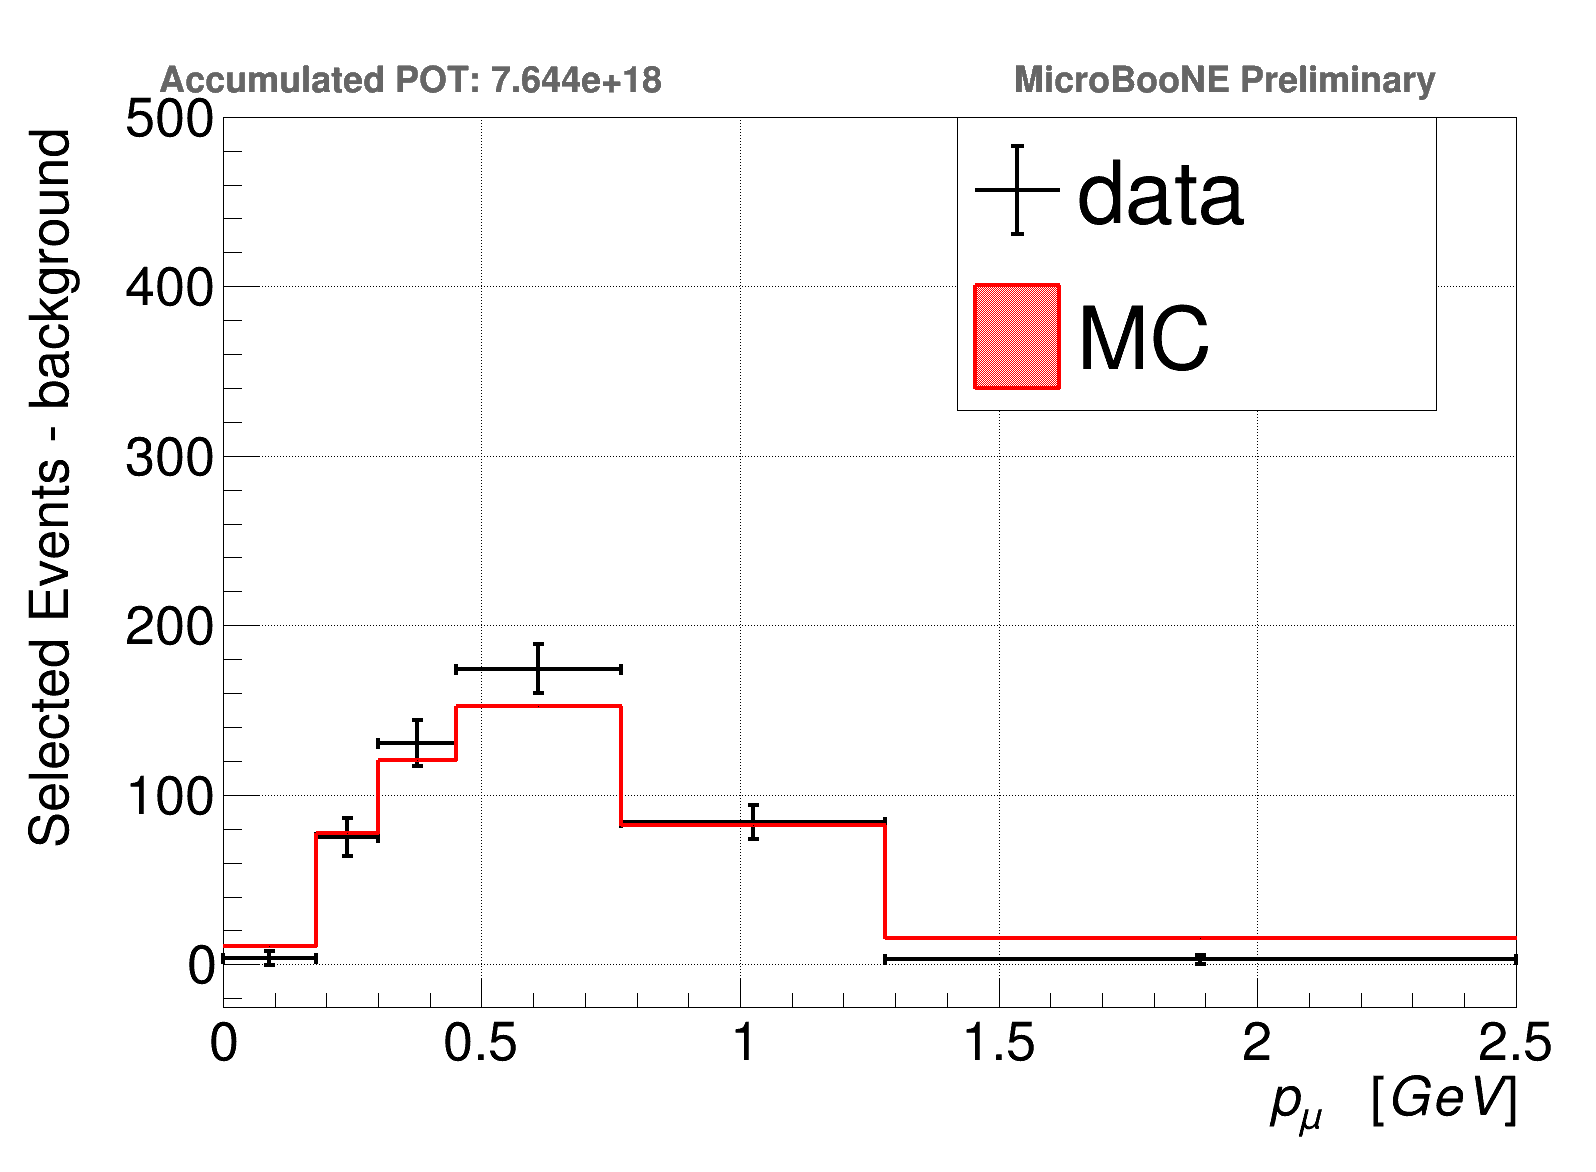

In [31]:
legend = ROOT.TLegend(0.6,0.65,0.9,0.9)
h_overlay_sig.SetLineColor(2)
legend.AddEntry(h_data,'data',"lep");
legend.AddEntry(h_overlay_sig,'MC',"f");
h_data.SetYTitle("Selected Events - background")
h_data.SetXTitle("p_{\mu} \t [GeV]")
h_data.SetLineWidth(3)
h_data.SetMaximum(500)

h_data.GetYaxis().SetTitleSize(0.05)
h_data.GetYaxis().SetTitleOffset(0.0)
h_data.GetYaxis().SetLabelSize(0.05)
h_data.GetXaxis().SetTitleSize(0.05)
h_data.GetXaxis().SetLabelSize(0.05)
h_data.GetXaxis().SetTitleOffset(1)
h_data.SetLineColor(ROOT.kBlack)
h_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.05)

h_data.Draw('E1')
h_overlay_sig.SetFillColor(0)
h_overlay_sig.SetLineWidth(4)
#h_overlay_sig.Draw('hist same')
h_overlay_sig.DrawCopy('Hist same')
h_overlay_sig.SetFillColor(2)
h_overlay_sig.SetFillStyle(3001)
h_overlay_sig.Draw('E2 same')
legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_data_bkgsubtracted.png")
c1.SaveAs(globale.outputdir_root + "h_data_bkgsubtracted.root")
c1.SaveAs(globale.outputdir_pdf + "h_data_bkgsubtracted.pdf")

h_data.Write("h_data_bkgsubtracted")
h_overlay_sig.Write("h_MC_bkgsubtracted")

In [32]:
for i in range(1,binnum+1):
    h_data.SetBinContent(i,h_data.GetBinContent(i)/h_data.GetBinWidth(i))
    h_overlay_sig.SetBinContent(i,h_overlay_sig.GetBinContent(i)/h_overlay_sig.GetBinWidth(i))
    h_data.SetBinError(i,h_data.GetBinError(i)/h_data.GetBinWidth(i))
    h_overlay_sig.SetBinError(i,h_overlay_sig.GetBinError(i)/h_overlay_sig.GetBinWidth(i))
    print h_data.GetBinContent(i)/h_data.GetBinWidth(i)

112.103404783
5217.36022562
5807.68280787
1703.31005089
322.60213221
1.9524933404


455

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_wocrt/png/h_data_bkgsubtracted_binwidth.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_wocrt/root/h_data_bkgsubtracted_binwidth.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_wocrt/pdf/h_data_bkgsubtracted_binwidth.pdf has been created


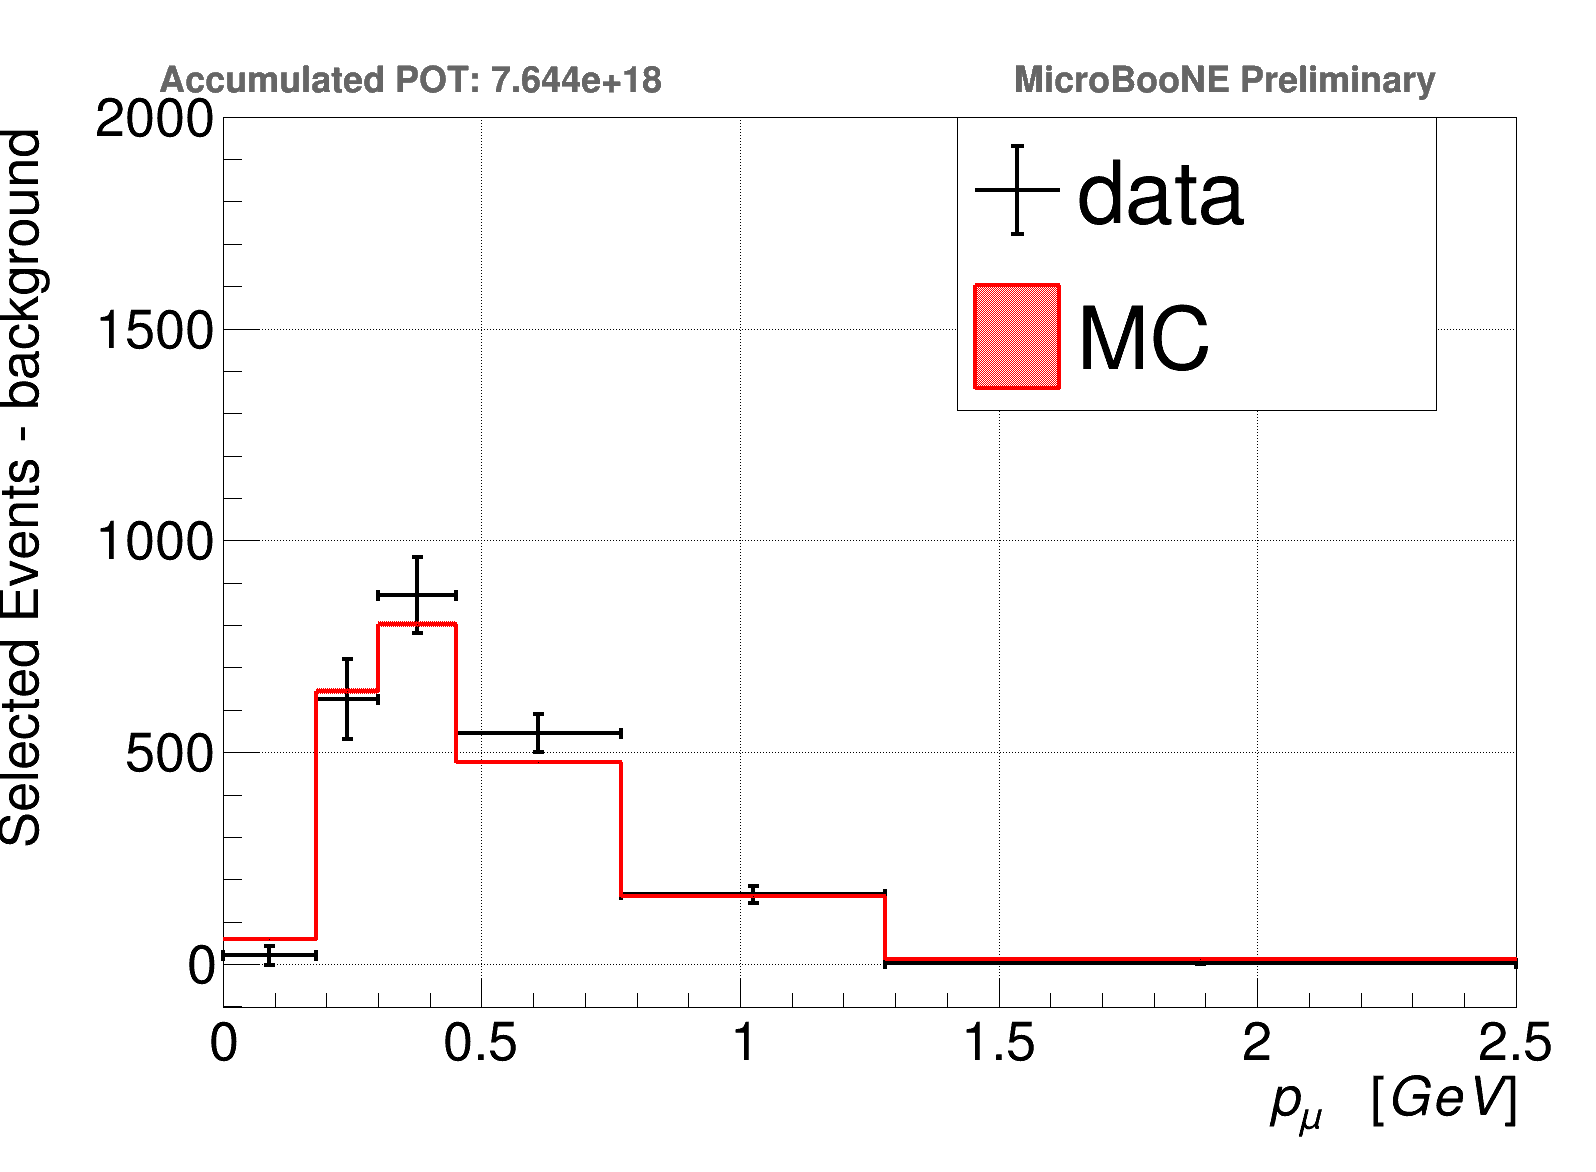

In [33]:
legend = ROOT.TLegend(0.6,0.65,0.9,0.9)
h_overlay_sig.SetLineColor(2)
legend.AddEntry(h_data,'data',"lep");
legend.AddEntry(h_overlay_sig,'MC',"f");
h_data.SetYTitle("Selected Events - background")
h_data.SetXTitle("p_{\mu} \t [GeV]")
h_data.SetLineWidth(3)
h_data.SetMaximum(2000)

h_data.GetYaxis().SetTitleSize(0.05)
h_data.GetYaxis().SetTitleOffset(0.0)
h_data.GetYaxis().SetLabelSize(0.05)
h_data.GetXaxis().SetTitleSize(0.05)
h_data.GetXaxis().SetLabelSize(0.05)
h_data.GetXaxis().SetTitleOffset(1)
h_data.SetLineColor(ROOT.kBlack)
h_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.05)

h_data.Draw('E1')
h_overlay_sig.SetFillColor(0)
h_overlay_sig.SetLineWidth(4)
#h_overlay_sig.Draw('hist same')
h_overlay_sig.DrawCopy('Hist same')
h_overlay_sig.SetFillColor(2)
h_overlay_sig.SetFillStyle(3001)
h_overlay_sig.Draw('E2 same')
legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_data_bkgsubtracted_binwidth.png")
c1.SaveAs(globale.outputdir_root + "h_data_bkgsubtracted_binwidth.root")
c1.SaveAs(globale.outputdir_pdf + "h_data_bkgsubtracted_binwidth.pdf")

h_data.Write("h_data_bkgsubtracted_binwidth")
h_overlay_sig.Write("h_MC_bkgsubtracted_binwidth")

In [34]:
for i in range(1,binnum+1):
    #print 'Entries in bin ',i,'-------------------------------------------------------------'
    print h_data.GetBinContent(i),h_data.GetBinError(i)

20.1786136627 22.4445057377
626.083251953 94.6151912896
871.152282715 90.7316125681
545.059204102 45.6549744132
164.527084351 19.4580592482
2.38204193115 2.19284382559


In [35]:
h_data.Divide(h_eff_tilde)
h_data.Scale(1.0/(N_tot*beam_flux*1e-38))

In [36]:
for i in range(1,binnum+1):
    #print 'Entries in bin ',i,'-------------------------------------------------------------'
    print h_data.GetBinContent(i),h_data.GetBinError(i)

0.0371471382678 0.0413235323444
0.700563132763 0.106230852383
0.746254503727 0.077987685644
0.38956618309 0.0327190235624
0.103944025934 0.012313637396
0.0014729622053 0.00135608376356


In [37]:
h_overlay_sig.Divide(h_eff_tilde)
h_overlay_sig.Scale(1.0/(N_tot*beam_flux*1e-38))

In [38]:
for i in range(1,binnum+1):
    #print 'Entries in bin ',i,'-------------------------------------------------------------'
    print h_data.GetBinContent(i),h_data.GetBinError(i)

0.0371471382678 0.0413235323444
0.700563132763 0.106230852383
0.746254503727 0.077987685644
0.38956618309 0.0327190235624
0.103944025934 0.012313637396
0.0014729622053 0.00135608376356


427

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_wocrt/png/h_xsec_corr.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_wocrt/root/h_xsec_corr.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_wocrt/pdf/h_xsec_corr.pdf has been created


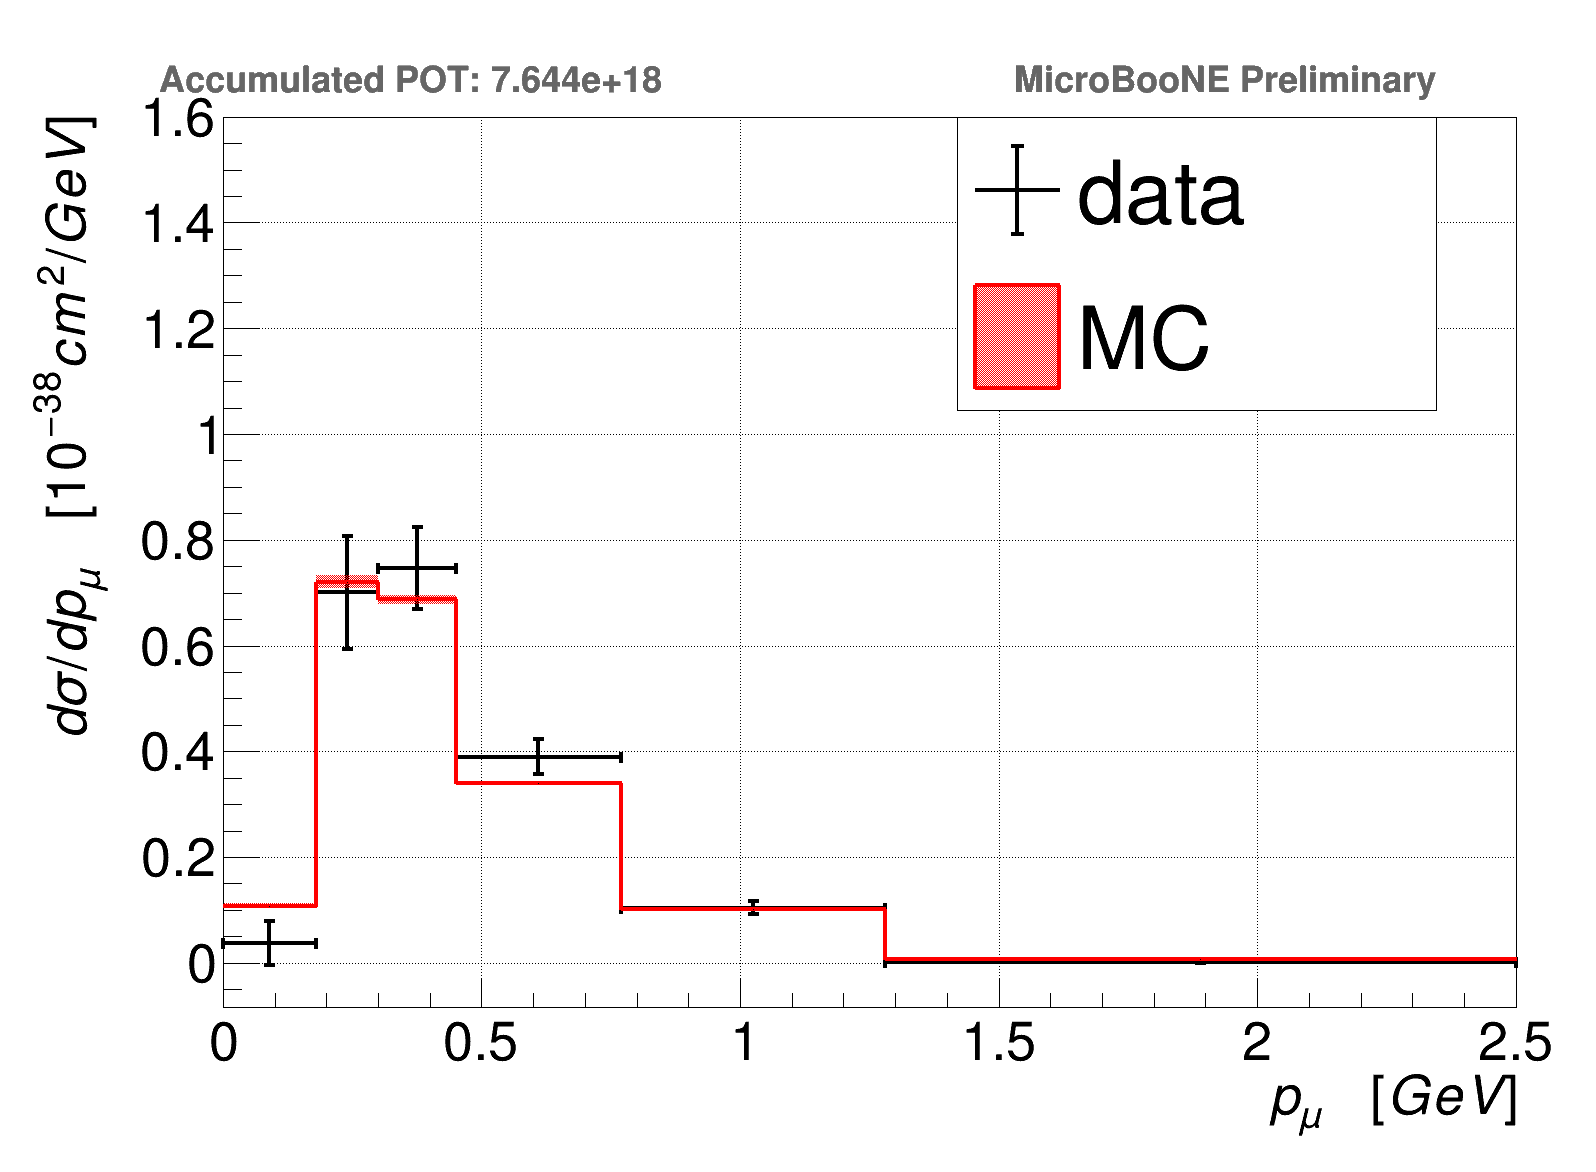

In [39]:
legend = ROOT.TLegend(0.6,0.65,0.9,0.9)
h_overlay_sig.SetLineColor(2)
legend.AddEntry(h_data,'data',"lep");
legend.AddEntry(h_overlay_sig,'MC',"f");
h_data.SetYTitle("d\sigma / dp_{\mu} \t [10^{-38} cm^{2}/GeV]")
h_data.SetXTitle("p_{\mu} \t [GeV]")
h_data.SetLineWidth(3)
h_data.SetMaximum(1.6)

h_data.GetYaxis().SetTitleSize(0.05)
h_data.GetYaxis().SetTitleOffset(0.0)
h_data.GetYaxis().SetLabelSize(0.05)
h_data.GetXaxis().SetTitleSize(0.05)
h_data.GetXaxis().SetLabelSize(0.05)
h_data.GetXaxis().SetTitleOffset(1)
h_data.SetLineColor(ROOT.kBlack)
h_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.05)

h_data.Draw('E1')
h_overlay_sig.SetFillColor(0)
h_overlay_sig.SetLineWidth(4)
#h_overlay_sig.Draw('hist same')
h_overlay_sig.DrawCopy('Hist same')
h_overlay_sig.SetFillColor(2)
h_overlay_sig.SetFillStyle(3001)
h_overlay_sig.Draw('E2 same')
legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_xsec_corr.png")
c1.SaveAs(globale.outputdir_root + "h_xsec_corr.root")
c1.SaveAs(globale.outputdir_pdf + "h_xsec_corr.pdf")

h_data.Write("h_xsec_data")
h_overlay_sig.Write("h_xsec_MC")

# Stop here is genie variation and flux variation is not run yet

In [40]:
# close the root file with all the histos
RootFile.Close()

In [ ]:
num_bins = h_xsec[0].GetNbinsX()

xsec_cov_matrix = np.zeros((num_bins,num_bins))
xsec_frac_cov_matrix = np.zeros((num_bins,num_bins))
#xsec_diff_matrix = np.zeros((num_bins))
for uni in range(num_universes):
    xsec_diff_matrix = np.zeros((num_bins))
    for b in range(num_bins):
        xsec_diff_matrix[b]= (h_xsec_cv.GetBinContent(b+1)-h_xsec[uni].GetBinContent(b+1) )
    #print np.matmul(xsec_diff_matrix,np.transpose(xsec_diff_matrix))
    xsec_cov_matrix = xsec_cov_matrix + xsec_diff_matrix.reshape(num_bins,1) * xsec_diff_matrix
xsec_cov_matrix = xsec_cov_matrix/num_universes
    
xsec_corr_matrix = np.zeros((num_bins,num_bins))
for i in range(num_bins): 
    for j in range(num_bins):
        xsec_corr_matrix[i][j] = xsec_cov_matrix[i][j]/(math.sqrt(xsec_cov_matrix[i][i]*xsec_cov_matrix[j][j]))
        xsec_frac_cov_matrix[i][j] = xsec_cov_matrix[i][j]/(h_xsec_cv.GetBinContent(i+1)*h_xsec_cv.GetBinContent(j+1))
